In [2]:
# import yfinance as yf   <- esto era para predecir stock, tristemente no funcionó y perdí la casa


#cargar datos y calculos mágicos
import numpy as np
import pandas as pd

#plots 
from matplotlib import pyplot as plt 
from plotly import graph_objects as go
from plotly import express as px
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot 
import seaborn as sns
import time

#tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM,GRU
# from tensorflow.keras.models import Sequential

#escalar datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import joblib #guardar el scaler




tf.random.set_seed(0)

In [3]:
df = pd.read_parquet('datos15til24resampledwxwy_sinhuecos.parquet.gzip')
df

,y,humext,pr,rafaga 10m,tasa precip,lluvia hoy,pres,cont lluvia,tempint,humint,...,radsolar,dir actual,lluvia desde 00:00,wx,wy,ds,day_sin,day_cos,year_sin,year_cos
ds,,,,,,,,,,,,,,,,,,,,,
2015-03-31 13:00:00,26.5,31.0,8.0,20.9,0.0,0.0,1014.5,3.3,26.6,48.0,...,462.0,211.500000,3.3,-8.863656,-7.049562,2015-03-31 13:00:00,0.000000,1.000000,0.000000,1.000000
2015-03-31 14:00:00,27.3,26.0,6.1,23.4,0.0,0.0,1013.6,3.3,26.6,45.0,...,175.0,193.483333,3.3,-10.551653,-3.243121,2015-03-31 14:00:00,0.258819,0.965926,0.000717,1.000000
2015-03-31 15:00:00,28.2,26.0,6.9,22.0,0.0,0.0,1012.9,3.3,25.8,45.0,...,0.0,188.616667,3.3,-11.587035,-2.221017,2015-03-31 15:00:00,0.500000,0.866025,0.001434,0.999999
2015-03-31 16:00:00,28.6,30.0,9.4,14.8,0.0,0.0,1012.0,3.3,25.8,45.0,...,0.0,193.116667,3.3,-8.023175,-1.828481,2015-03-31 16:00:00,0.707107,0.707107,0.002150,0.999998
2015-03-31 17:00:00,28.6,31.0,9.8,14.8,0.0,0.0,1011.9,3.3,25.8,42.0,...,0.0,174.400000,3.3,-8.238028,0.288265,2015-03-31 17:00:00,0.866025,0.500000,0.002867,0.999996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-12 08:00:00,15.7,57.0,7.2,7.2,0.0,0.0,1015.5,2583.3,25.2,30.0,...,335.0,292.700000,0.0,1.481261,-3.662468,2024-11-12 08:00:00,-0.965926,0.258819,-0.686536,-0.727096
2024-11-12 09:00:00,18.2,47.0,6.7,13.3,0.0,0.0,1015.5,2583.3,24.8,31.0,...,582.0,303.016667,0.0,3.299500,-5.099136,2024-11-12 09:00:00,-0.866025,0.500000,-0.687057,-0.726603
2024-11-12 10:00:00,19.9,37.0,4.8,14.8,0.0,0.0,1015.1,2583.3,25.3,29.0,...,796.0,301.133333,0.0,4.167287,-5.374683,2024-11-12 10:00:00,-0.707107,0.707107,-0.687578,-0.726111


In [3]:
#Create a new 'ds' column by combining Date and Hour (Prophet expects a column 'ds' for time variable)

df.columns = df.columns.str.lower()

#parquet
# df['ds'] = pd.to_datetime((df['fecha'] + ' ' + df['hora']), format="%d/%m/%y %H:%M")


# #csv
# # df['ds'] = pd.to_datetime((df['fecha'] + ' ' + df['hora']), format="%m/%d/%Y %H:%M")

df['ds']=df.index
df['ds']



# df=df.drop(columns=['fecha','hora'],axis=1)
# df=df.set_index('ds',drop=False)

#resample de hora en hora, porque hay datos que fueron grabados cada 30 min o cada 5 en el listado
#por algún motivo
# df = df.resample("h", label="right").last()


#cambiar nombres
df = df.rename(columns={
'temp ext':'y',
'hum ext':'humext',
'temp int':'tempint',
'humedad int':'humint',
'presión' : 'pres',
'temp ap': 'tempap',
"rad solar t": "radsolar",
})


# #añadir viento como dirección y vector

# wv = df.pop('vel viento')
# wd_rad = df.pop('dir prom')*np.pi / 180
# df['wx'] = wv*np.cos(wd_rad)
# df['wy'] = wv*np.sin(wd_rad)

#lo quité a lo de arriba porque ya lo metí en el dataframe




#borro las columnas que siempre son 0

# siemprecero=['uv','solar rad','evap','evap anual','horas de sol','rg-11 rain']
# df=df.drop(columns=siemprecero,axis=1)

#borro las filas que tienen más de un valor para el mismo horario (no sé por qué pasó esto pero pasó)

# df=df.drop_duplicates(subset=df['ds'])


df=df.fillna(method='ffill')
nan_rows = df[df['ds'].isnull()]
nan_rows

df.head()



C:\Users\soysa\AppData\Local\Temp\ipykernel_22836\1933971463.py:59: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,y,humext,pr,rafaga 10m,tasa precip,lluvia hoy,pres,cont lluvia,tempint,humint,...,radsolar,dir actual,lluvia desde 00:00,wx,wy,ds,day_sin,day_cos,year_sin,year_cos
ds,,,,,,,,,,,,,,,,,,,,,
2015-03-31 13:00:00,26.5,31.0,8.0,20.9,0.0,0.0,1014.5,3.3,26.6,48.0,...,462.0,211.500000,3.3,-8.863656,-7.049562,2015-03-31 13:00:00,0.000000,1.000000,0.000000,1.000000
2015-03-31 14:00:00,27.3,26.0,6.1,23.4,0.0,0.0,1013.6,3.3,26.6,45.0,...,175.0,193.483333,3.3,-10.551653,-3.243121,2015-03-31 14:00:00,0.258819,0.965926,0.000717,1.000000
2015-03-31 15:00:00,28.2,26.0,6.9,22.0,0.0,0.0,1012.9,3.3,25.8,45.0,...,0.0,188.616667,3.3,-11.587035,-2.221017,2015-03-31 15:00:00,0.500000,0.866025,0.001434,0.999999
2015-03-31 16:00:00,28.6,30.0,9.4,14.8,0.0,0.0,1012.0,3.3,25.8,45.0,...,0.0,193.116667,3.3,-8.023175,-1.828481,2015-03-31 16:00:00,0.707107,0.707107,0.002150,0.999998
2015-03-31 17:00:00,28.6,31.0,9.8,14.8,0.0,0.0,1011.9,3.3,25.8,42.0,...,0.0,174.400000,3.3,-8.238028,0.288265,2015-03-31 17:00:00,0.866025,0.500000,0.002867,0.999996


In [4]:
timestamp_s = df['ds'].map(pd.Timestamp.timestamp)
# timestamp_s = df.index.map(pd.Timestamp.timestamp)
timestamp_s=timestamp_s-timestamp_s.iloc[0]
day = 24*60*60 #esto porque los datos estÃ¡n en minutos como minima resoluciÃ³n
year = (365.2425)*day

df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))


In [5]:
columnas_a_usar=['y','wx','wy','humext','pr',
                 'day_cos','day_sin','year_cos','year_sin']

df_input=df[columnas_a_usar]
# df_input

start_date = '2019-05-01 00:00:00'
# end_date = '2021-08-20 13:13:00'
#nuevo:
end_date = '2022-12-17 13:00:00'

# Filtrar el DataFrame usando .loc[]
df_input = df_input[(df_input.index >= start_date) & (df_input.index <= end_date)]
df_input

,y,wx,wy,humext,pr,day_cos,day_sin,year_cos,year_sin
ds,,,,,,,,,
2019-05-01 00:00:00,16.0,-0.084001,6.560992,50.0,5.6,-0.965926,2.588190e-01,0.865582,0.500766
2019-05-01 01:00:00,15.3,-0.543392,6.133613,55.0,6.3,-1.000000,6.672928e-13,0.865223,0.501387
2019-05-01 02:00:00,15.1,-0.629431,4.947524,52.0,5.3,-0.965926,-2.588190e-01,0.864864,0.502007
2019-05-01 03:00:00,14.5,0.967298,7.187465,56.0,5.8,-0.866025,-5.000000e-01,0.864504,0.502627
2019-05-01 04:00:00,14.3,0.953462,5.001802,60.0,6.6,-0.707107,-7.071068e-01,0.864143,0.503246
...,...,...,...,...,...,...,...,...,...
2022-12-17 09:00:00,20.8,1.571527,9.486415,55.0,11.4,0.500000,-8.660254e-01,-0.218354,-0.975870
2022-12-17 10:00:00,21.9,5.078725,7.393205,53.0,11.9,0.707107,-7.071068e-01,-0.217654,-0.976026
2022-12-17 11:00:00,22.9,6.642198,3.994818,51.0,12.3,0.866025,-5.000000e-01,-0.216955,-0.976182


(<Axes: title={'center': 'year wave'}, xlabel='ds'>,
 <Axes: title={'center': 'year wave'}, xlabel='ds'>)

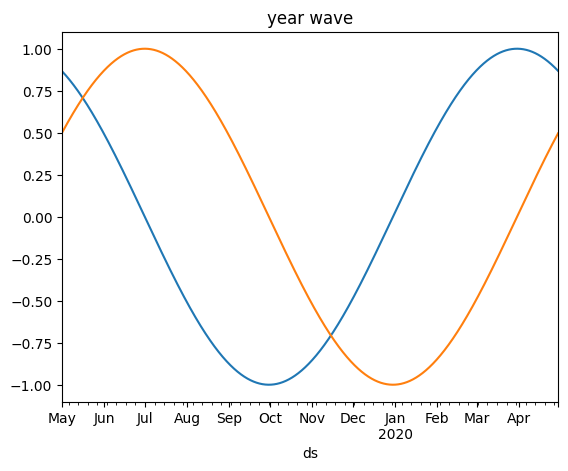

In [6]:
df_input['year_cos'][:365*24].plot(),df_input['year_sin'][:365*24].plot(title='year wave')


(<Axes: title={'center': 'day wave'}, xlabel='ds'>,
 <Axes: title={'center': 'day wave'}, xlabel='ds'>)

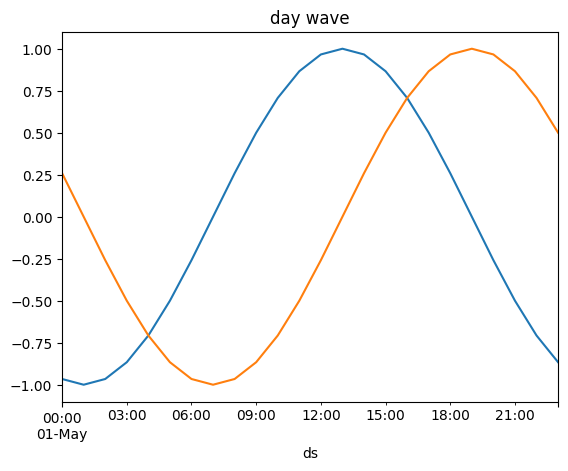

In [7]:
df_input['day_cos'][:24].plot(),df_input['day_sin'][:24].plot(title='day wave')

Text(0.5, 1.0, 'Correlation Heatmap')

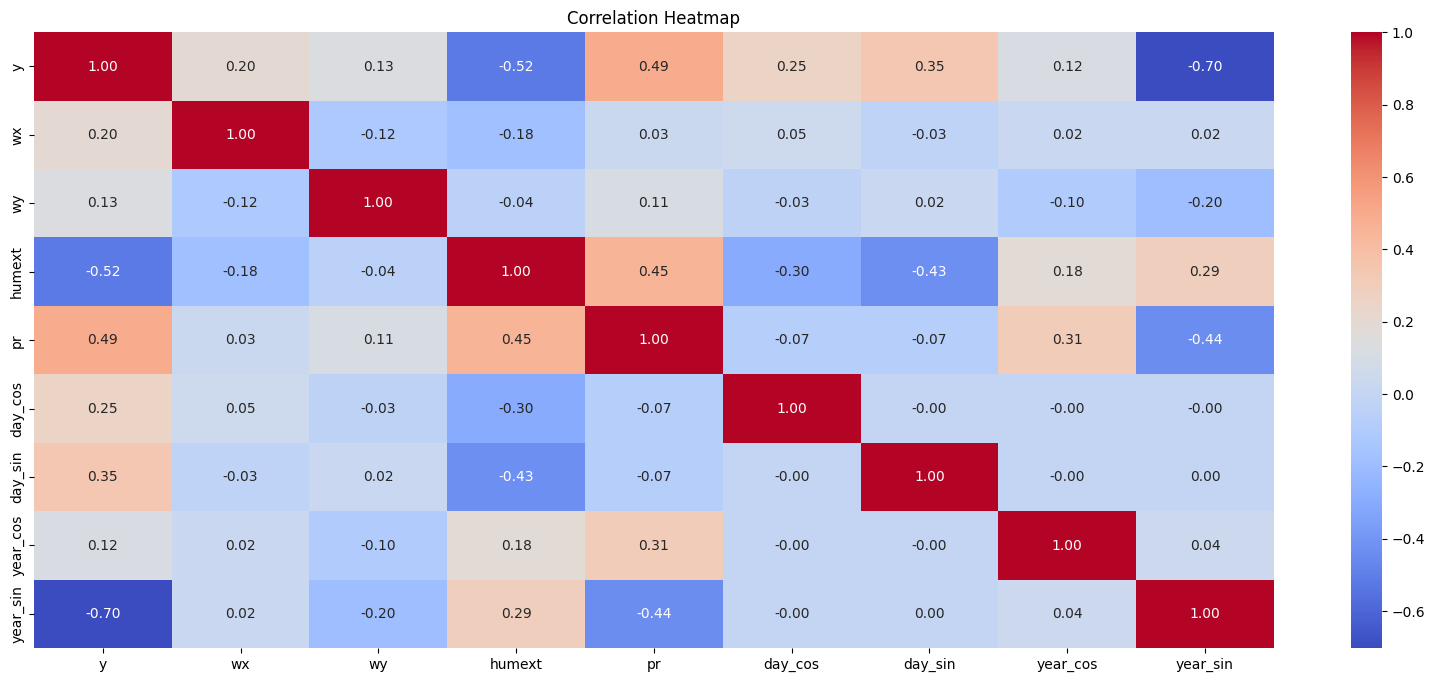

In [8]:
plt.figure(figsize=(20, 8))
sns.heatmap(df_input.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')

In [9]:
#constantes de corte
len_100=len(df_input)
len_70=int(len_100*.7)
len_80=int(len_100*.8)
len_90=int(len_100*.9)

#constantes de predicción

n_lookback=24*7
n_forecast=24*2
n_columnas=9

In [ ]:
def array_to_X_y(array_datos,n_lookback=n_lookback,n_forecast=n_forecast):
    # df_np= df.to_numpy()
    #print(np.shape(df_np))
    X=[]
    y=[]
    for i in range(len(array_datos)-n_lookback-n_forecast): #itera X - 168 - 48 por defecto
        row = [r for r in array_datos[i:i+n_lookback]]      #hace un array de forma de (imax, n_lookback , columnas de input )
        X.append(row)
        label=[array_datos[i+n_lookback:i+n_lookback+n_forecast,0]] #esto cambiar por nombre de columna porque si no va a ser horrible 
                                                                    # 0 es temperatura
        # label=[df_np[i+n_lookback:i+n_lookback+n_forecast,0],df_np[i+n_lookback:i+n_lookback+n_forecast,4]] #esto cambiar por nombre de columna porque si no va a ser horrible 
        #recordar cuál columna es cada índice
        y.append(np.array(label).T)
        # print(np.shape(y))
    # print(y[-1])
    return np.array(X),np.array(y)


def plot_pred(fecha,dataframe,modelo,scaler,columna=0,n_columnas=n_columnas,horas_prediccion=n_forecast):
    """Plotea la predicción de dos días posteriores a la fecha indicada (en formato DD-MM-AAAA HH:00)
    tomando una semana de datos anteriores con el modelo indicado"""
    """ df_input tiene que tener un índice en formato fecha con frecuencia de hora """
    fecha_timestamp=pd.Timestamp(fecha)
    añomes=f'{fecha_timestamp.year}-{fecha_timestamp.month}'
    
    feature=columnas_a_usar[columna]
    
    c=dataframe.loc[:fecha]
    c=c[-n_lookback:]
    c_array=c.to_numpy()
    c_array=scaler.transform(c_array)
    c_array=np.reshape(c_array,(1,*c_array.shape))
    print(c_array.shape)
    
    pred=modelo.predict(c_array).flatten()            #datos escalados minmax(0,1)
    
    pred_input_scaler=np.column_stack([np.zeros(shape=(n_forecast,columna)), pred, np.zeros(shape=(n_forecast,n_columnas-1-columna))])
    print(pred_input_scaler.shape)
    
    pred_scaled=scaler.inverse_transform(pred_input_scaler)[:,columna]
 
    tiempo_lookback=c.index
    tiempo_forecast=pd.date_range(start=fecha, periods=n_forecast, freq='h')
    
    tiempo_forecast+=pd.to_timedelta(1, unit='h') #añado una hora porque arranca a predecir después de la fecha indicada
    
    # print(tiempo_lookback[-1])
    # print(tiempo_forecast)
    
    pic1=go.Scatter(x=tiempo_forecast[:horas_prediccion],y=pred_scaled[:horas_prediccion],name='pred')
    pic2=go.Scatter(x=tiempo_lookback, y= c[feature],name='input')
    pic3=go.Scatter(x=dataframe.loc[añomes][feature].index, y=dataframe.loc[añomes][feature],name='x_test_real')
    fig = make_subplots(specs=[[{"secondary_y": False}]])
    fig.add_trace(pic1)
    fig.add_trace(pic2)
    fig.add_trace(pic3)

    fig['layout'].update(title = f'{feature}, predicción y real',xaxis=dict(tickangle=-90))
    # fig['layout'].update(height = 800, width = 1400, title = f'{feature}, predicción y real',xaxis=dict(tickangle=-90))
    iplot(fig)
    # return pd.DataFrame({columnas_a_usar[columna]:pred_scaled},index=tiempo_forecast)
    
    
    
def get_pred(fecha,modelo,scaler,dataframe=df.copy()[columnas_a_usar],columna=0,n_columnas=n_columnas,horas_prediccion=n_forecast,verbose=False):
   
    
    c=dataframe.loc[:fecha]
    c=c[-n_lookback:]
    c_array=c.to_numpy()
    c_array=scaler.transform(c_array)
    c_array=np.reshape(c_array,(1,*c_array.shape))
    # print(c_array.shape)
    
    pred=modelo.predict(c_array,verbose=verbose).flatten()            #datos escalados minmax(0,1)
    
    pred_input_scaler=np.column_stack([np.zeros(shape=(n_forecast,columna)), pred, np.zeros(shape=(n_forecast,n_columnas-1-columna))])
    # print(pred_input_scaler.shape)
    
    pred_scaled=scaler.inverse_transform(pred_input_scaler)[:,columna]
    # print(pred_scaled.shape)
    tiempo_forecast=pd.date_range(start=fecha, periods=n_forecast, freq='h')
    
    tiempo_forecast+=pd.to_timedelta(1, unit='h') #añado una hora porque arranca a predecir después de la fecha indicada
    
    return pred_scaled,tiempo_forecast

In [11]:
df.loc['2021-4-16':'2024-6-16':48].index

DatetimeIndex(['2021-04-16', '2021-04-18', '2021-04-20', '2021-04-22',
               '2021-04-24', '2021-04-26', '2021-04-28', '2021-04-30',
               '2021-05-02', '2021-05-04',
               ...
               '2024-05-28', '2024-05-30', '2024-06-01', '2024-06-03',
               '2024-06-05', '2024-06-07', '2024-06-09', '2024-06-11',
               '2024-06-13', '2024-06-15'],
              dtype='datetime64[ns]', name='ds', length=579, freq=None)

In [12]:
df_input.columns

Index(['y', 'wx', 'wy', 'humext', 'pr', 'day_cos', 'day_sin', 'year_cos',
       'year_sin'],
      dtype='object')

In [13]:



df_np_full=df_input.to_numpy()                 #transformo a numpy para luego usar el scaler
df_np_train=df_np_full.copy()[:len_70,:]            #hago una copia para evitar mutar el original cuando reescale
df_np_val=df_np_full.copy()[len_70:len_90,:]
df_np_test=df_np_full.copy()[len_90:,:]

#esto para entrenar con + datos
df_np80_train=df_np_full.copy()[:len_80,:]    
df_np80_val=df_np_full.copy()[len_80:,:] 


df_np_full.shape , df_np_train.shape , df_np_test.shape , df_np_val.shape

((31838, 9), (22286, 9), (3184, 9), (6368, 9))

In [14]:
#escalo usando el dataset de entrenamiento
#sinceramente no sé la motivación al 100% pero lo vi recomendado en un par de lugares, nunca escalar junto a
#los datos de validación y testeo para el entrenamiento inicial
train_scaler= MinMaxScaler()

df_np_train_scaled = train_scaler.fit_transform(df_np_train)
df_np_val_scaled = train_scaler.transform(df_np_val)
df_np_test_scaled = train_scaler.transform(df_np_test)

np80_scaler=MinMaxScaler()

df_np80_train=np80_scaler.fit_transform(df_np80_train)
df_np80_val=np80_scaler.transform(df_np80_val)

# joblib.dump(np80_scaler, 'radsolar_np80_scaler.gz')

In [15]:
X80_train,y80_train=array_to_X_y(df_np80_train)
X80_val,y80_val=array_to_X_y(df_np80_val)


X_train, y_train = array_to_X_y(df_np_train_scaled)
X_val, y_val = array_to_X_y(df_np_val_scaled)
X_test, y_test = array_to_X_y(df_np_test_scaled)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


[[0.3559719 ]
 [0.35362998]
 [0.35128806]
 [0.3559719 ]
 [0.35831382]
 [0.36533958]
 [0.38407494]
 [0.40983607]
 [0.42857143]
 [0.470726  ]
 [0.46838407]
 [0.48477752]
 [0.47306792]
 [0.46604215]
 [0.470726  ]
 [0.48009368]
 [0.44964871]
 [0.43559719]
 [0.42622951]
 [0.4028103 ]
 [0.38173302]
 [0.37236534]
 [0.37002342]
 [0.38407494]
 [0.38875878]
 [0.38875878]
 [0.38875878]
 [0.38875878]
 [0.40515222]
 [0.43325527]
 [0.46604215]
 [0.53395785]
 [0.56674473]
 [0.58782201]
 [0.59016393]
 [0.61358314]
 [0.63934426]
 [0.60187354]
 [0.58079625]
 [0.56674473]
 [0.54098361]
 [0.52693208]
 [0.50351288]
 [0.49180328]
 [0.46604215]
 [0.43091335]
 [0.42388759]
 [0.41686183]]
[[0.67681499]
 [0.72833724]
 [0.72833724]
 [0.76112412]
 [0.735363  ]
 [0.7236534 ]
 [0.72131148]
 [0.70725995]
 [0.66510539]
 [0.62295082]
 [0.60187354]
 [0.57611241]
 [0.53629977]
 [0.50351288]
 [0.47540984]
 [0.44730679]
 [0.42857143]
 [0.4028103 ]
 [0.41217799]
 [0.45199063]
 [0.5058548 ]
 [0.55503513]
 [0.60187354]
 [0.6

((22070, 168, 9),
 (22070, 48, 1),
 (6152, 168, 9),
 (6152, 48, 1),
 (2968, 168, 9),
 (2968, 48, 1))

In [16]:
# fit the model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(n_lookback, n_columnas)))
model.add(GRU(units=50))
model.add(Dense(n_forecast))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=32, batch_size=32,validation_data=(X_val,y_val))

c:\Users\soysa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 168, 50)        │         9,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         2,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,898 (105.07 KB)

 Trainable params: 26,898 (105.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
690/690 ━━━━━━━━━━━━━━━━━━━━ 76s 104ms/step - loss: 0.0319 - val_loss: 0.0066
Epoch 2/32
690/690 ━━━━━━━━━━━━━━━━━━━━ 65s 95ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 3/32
690/690 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - loss: 0.0056 - val_loss: 0.0061
Epoch 4/32
690/690 ━━━━━━━━━━━━━━━━━━━━ 64s 93ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 5/32
690/690 ━━━━━━━━━━━━━━━━━━━━ 64s 93ms/step - loss: 0.0053 - val_loss: 0.0059
Epoch 6/32
690/690 ━━━━━━━━━━━━━━━━━━━━ 64s 92ms/step - loss: 0.0053 - val_loss: 0.0059
Epoch 7/32
690/690 ━━━━━━━━━━━━━━━━━━━━ 64s 92ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 8/32
690/690 ━━━━━━━━━━━━━━━━━━━━ 63s 92ms/step - loss: 0.0051 - val_loss: 0.0058
Epoch 9/32
690/690 ━━━━━━━━━━━━━━━━━━━━ 63s 92ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 10/32
690/690 ━━━━━━━━━━━━━━━━━━━━ 64s 93ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 11/32
690/690 ━━━━━━━━━━━━━━━━━━━━ 63s 92ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 12/32
690/690 ━━━━━━━━━

In [106]:
model.save('GRUcorto-10-12.keras')
joblib.dump(train_scaler,'GRUcorto-10-12-scaler.gz')

['GRUcorto-10-12-scaler.gz']

In [63]:
model=tf.keras.models.load_model('GRUcorto-10-12.keras')

train_scaler=joblib.load('GRUcorto-10-12-scaler.gz')
model2=tf.keras.models.load_model('GRU80_20-10-12.keras')
np80_scaler=joblib.load('GRU80_20-10-12-scaler.gz')

model3=tf.keras.models.load_model('GRU80_20.keras')
np80_scaler2 = joblib.load('GRU80_20-scaler.gz')


In [ ]:
error_rel_mape=np.average(np.abs(real-dy)/real)
print(error_rel_mape)
MSE=np.average((real-dy)**2)
print(MSE)
ME=np.average(np.abs(real-dy))
print(ME)

In [ ]:
temp_tot=[]
t_tot=df.loc['2023-1-1':'2024-11-30'].index
temp_real=df.loc['2023-1-1':'2024-11-30']['y'].to_numpy()
test=[]
for fechas in df.loc['2023-1-1':'2024-11-30':48].index:
    temperatura,tiempo = get_pred(fechas,modelo=model3,scaler=np80_scaler2)
    # print(tiempo[0])
    temp_tot=np.concatenate((temp_tot,temperatura))
    test.append(tiempo)
    # print(len(test),temp_tot.shape)
test=np.array(test).flatten()

In [77]:
lrpm=0
offset=0
cut=168
# px.line()
pic1=go.Scatter(x=test[lrpm:cut+lrpm], y=temp_tot[lrpm:cut+lrpm],name='predict')
pic2=go.Scatter(x=t_tot[lrpm:cut+lrpm], y=temp_real[lrpm:cut+lrpm],name='x_test_real')
# pic3=go.Scatter(x=corte.index,y=corte['y'],name='real')
fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(pic1)
fig.add_trace(pic2)
# fig.add_trace(pic3)
fig['layout'].update( title = 'temperatura, predicción y real',xaxis=dict(tickangle=-90))
iplot(fig)



In [65]:
error_rel_mape=np.average(np.abs(temp_real[1:]-temp_tot[:16356])/temp_real[1:])
print(error_rel_mape)
MSE=np.average((temp_real[1:]-temp_tot[:16356])**2)
print(MSE)
ME=np.average(np.abs(temp_real[1:]-temp_tot[:16356]))
print(ME)

0.15297450903100082
15.842113047977637
2.924848192507858


In [87]:
np.max(temp_real)

41.0

In [29]:
#full train

model2 = Sequential()
model2.add(GRU(units=50, return_sequences=True, input_shape=(n_lookback, n_columnas)))
model2.add(GRU(units=50))
model2.add(Dense(n_forecast))
model2.summary()
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(X80_train, y80_train, epochs=32, batch_size=32,validation_data=(X80_val,y80_val))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 168, 50)        │         9,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         2,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,898 (105.07 KB)

 Trainable params: 26,898 (105.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
790/790 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - loss: 0.0291 - val_loss: 0.0064
Epoch 2/32
790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - loss: 0.0052 - val_loss: 0.0061
Epoch 3/32
790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 84ms/step - loss: 0.0049 - val_loss: 0.0060
Epoch 4/32
790/790 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 5/32
790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 6/32
790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - loss: 0.0046 - val_loss: 0.0059
Epoch 7/32
790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 84ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 8/32
790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - loss: 0.0044 - val_loss: 0.0058
Epoch 9/32
790/790 ━━━━━━━━━━━━━━━━━━━━ 69s 87ms/step - loss: 0.0043 - val_loss: 0.0058
Epoch 10/32
790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 83ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 11/32
790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 84ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 12/32
790/790 ━━━━━━━━━━

In [77]:
model2.save('GRU80_20-10-12.keras')
joblib.dump(np80_scaler,'GRU80_20-10-12-scaler.gz')

['GRU80_20-10-12-scaler.gz']